In [24]:
from qiskit.circuit import Delay, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

import sys
import os

sys.path.append(os.path.abspath("..\\..\\..\\.."))
from objects.shor_code_circuit import ShorCodeCircuit
from functions import *

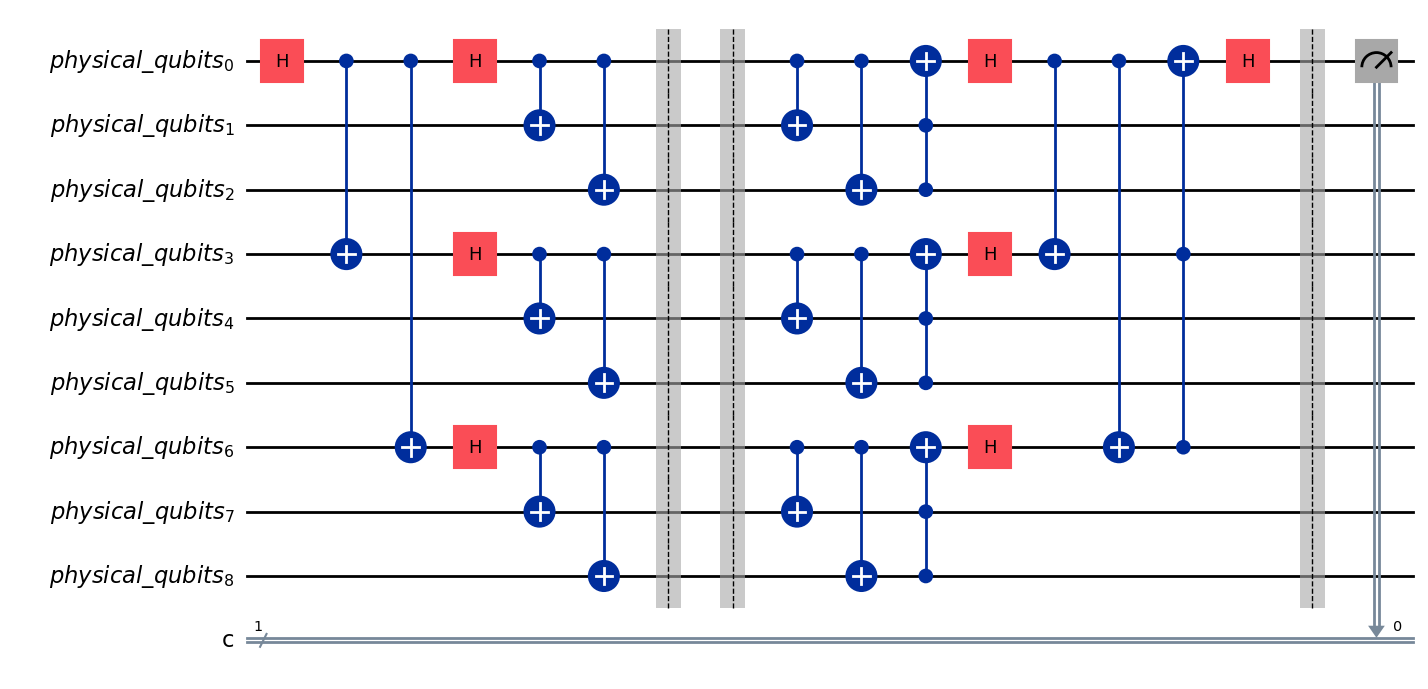

In [25]:
def load_circuit(delay=0, initial_state='0'):
    
    qc = ShorCodeCircuit(1)

    if initial_state == '1':
        qc.physical_quantum_circuit.x(0)
    elif initial_state == '+':
        qc.physical_quantum_circuit.h(0)
    elif initial_state == '-':
        qc.physical_quantum_circuit.h(0)
        qc.physical_quantum_circuit.x(0)
    else:
        pass

    qc.encode()

    qc.barrier()

    if delay > 0:
        for i in range(qc.physical_qubit_count):
            qc.append_unitary_error(Delay(delay), i)

    qc.barrier()

    qc.decode()

    if initial_state in ['+', '-']:
        qc.physical_quantum_circuit.h(0)

    qc.barrier()

    # qc.measure_all(basis='all')

    circuit = qc.physical_quantum_circuit
    creg = ClassicalRegister(1, 'c')
    circuit.add_register(creg)
    circuit.measure(circuit.qubits[0], creg)

    return qc

qc = load_circuit(initial_state='+')
qc.draw_physical_circuit('mpl')

In [26]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_sherbrooke")

In [27]:
phy_qc = qc.physical_quantum_circuit
isa_circuit = transpile(phy_qc, backend, scheduling_method="asap", optimization_level=3)
print(f"Circuit Depth: {qc.physical_quantum_circuit.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")

Circuit Depth: 15
Transpiled Circuit Depth: 118


In [28]:
dt = backend.configuration().dt * 10**9
print(f'dt = {round(dt, 3)} ns')

dt = 0.222 ns


In [29]:
# t_array = [t*90_000 for t in range(0, 3)]
t_array = [0]
print([round(t*dt * 10**(-3), 3) for t in t_array])

[0.0]


In [8]:
# circuits = []

# for t in t_array:

#     qc = load_circuit(t, initial_state='1')

#     isa_circuit = get_transpile(qc.physical_quantum_circuit, backend, iterations=100,
#                                 # initial_layout=[122, 111, 121, 123, 104, 120, 124, 119, 125]
#                                 )
    
#     circuits.append(isa_circuit)

#     print(f"Circuit Depth: {circuits[-1].depth()}")
#     print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")
#     print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")
#     print(get_layout(circuits[-1], qb_len=9))
#     print('\n')

In [31]:
circuits = []
qc = load_circuit(initial_state='1')

circuits.append(get_transpile(qc.physical_quantum_circuit, backend, iterations=100,
                                
                                ))
    

print(f"Circuit Depth: {circuits[-1].depth()}")
# print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")
print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")
print(get_layout(circuits[-1], qb_len=9))

Circuit Depth: 101
Total Duration: 17.493 us
[122, 123, 111, 121, 104, 124, 120, 125, 103]


C:\Users\marzu\AppData\Local\Temp\ipykernel_35100\1176279304.py:11: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")


In [32]:
simulation_result = sampler_simulation(qc.physical_quantum_circuit, 500)

print(f"{simulation_result.data['c'].get_counts()}")

{'1': 500}


In [ ]:
sampler = SamplerV2(backend=backend)
shots = 2000
# job = sampler.run(circuits, shots=shots)

# job = service.job('cz12xt739f40008rttcg') # sherbrooke, 0 encoder particular, shots = 500, t_array = [t*90_000 for t in range(0, 3)] -> 92.8%
# job = service.job('cz574081xvhg008eb2x0') # sherbrooke, t_array = [0], 1 encoder universal -> 92.4%
# job = service.job('cz5811m39f40008sgwa0') # sherbrooke, t_array = [0], |+> encoder universal, medir en base X -> 79.4%
# job = service.job('cz58mg21xvhg008ebhr0') # 2000 shots -> 83,1% (+-5%)
job = service.job('cz5jvhy1xvhg008ee2r0') # 1 encoder universal con 2000 shots-> 90.4%


pub_result = job.result()

In [35]:
results = extract_results_IBM(pub_result, type='percentage')['c']
print(results)

[{'0': 9.65, '1': 90.35}]
